In [12]:
# author : Myron Kukhta (xkukht01)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import os

In [13]:
class SLR():
    '''
    
    Class for implementing a Simple Linear Regression(SLR) algorithm
    based on data on the ratio of sizes and prices of apartments in Moscow


    '''
    def __init__(self):
        '''
        
        Class constructor

        Attributes:
            PATH_TO_DATASET [str]: relative path to dataset
            _dataset [pd.DataFrame]: dataframe with dataset
            _solv [pd.DataFrame]: dataframe with experiments output
             
        '''
        self.PATH_TO_DATASET = 'dataset/flats_moscow.csv'
        self._dataset= pd.DataFrame()
        self._solv = pd.DataFrame(columns=['cnt', 'Real Y', 'Predict Y', 'B1', 'B2', 'Sum of E', 'r', 'R'])


    def LoadDataSet(self)->None:
        '''
        
        Load dataset from csv to DataFrame and choosing only important data(price and area)

        '''
        path = os.path.join(os.getcwd(), self.PATH_TO_DATASET)
        
        if not os.path.isfile(path):  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path {self.PATH_TO_DATASET} is not exist')
        
        self._dataset= pd.read_csv(self.PATH_TO_DATASET)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path {self.PATH_TO_DATASET} is empty. Counting is aborted.')



    def _Sampling(self, full_dataset:bool, random_sampling:bool, cnt_sample:int)->tuple[np.array, np.array]:
        '''
        Description:
            Datasets sampling

        Parametrs:
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample  [bool]: items number in sample

        '''
        sample = self._dataset.loc[:, ['price', 'totsp']]
        
        if random_sampling:
            cnt_samples = np.random.randint(20, 100)
        else:
            cnt_samples = cnt_sample
        
        if not full_dataset:
            try:
                sample = sample.sample(n=cnt_samples)
            except ValueError as e:
                raise Exception("Warning! Requested count of items in sample more than have dataset on actual data range.")
        
        return sample['totsp'].values, sample['price'].values

    
    def _Vizualization(self, x:np.array, y:np.array, y_predict:np.array, e:np.array, with_err:bool)->None:
        '''
        
        Description:
            Experiments vizualization by plot

        Parametrs:
            x [np.array]: independent data
            y [np.array]: original dependent data
            y_predict [np.array]: prdicted dependet data
        
        '''
        plt.scatter(x, y, marker='o', color='blue')  # original relation

        plt.axis([x.min()-10, x.max()+10, y.min()-10, y.max()+10])
        
        plt.plot(x, y_predict, color='red')  # prediction

        if with_err:  # viz relation between predicted and real Y
            point = 0
            for x_it, y_it, y_pr_it, e_it in np.nditer([x, y, y_predict, e]):  # one time iteration on many np arrays
                point += 1
                print(f'Point {point}: y_original={y_it}, y_predict={y_pr_it}, error={e_it}')
                plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green')  # e = y_real - y_predict

        plt.xlabel('area ( m^2)')
        plt.ylabel('cost (1000 $)')
        plt.title('Area vs cost')
        
        plt.show()

        
    def _Alg(self, x:np.array, y:np.array)->tuple[np.array, int, float, int, int, np.array, float, float]:
        '''

        Description:
            Core of SLR
            SLR:    Y_PREDICT = b1 + b2*X

                         sum((X-mean(X))*(Y-mean(Y)))
                    b2 = -------------------------
                         sum((X-mean(X))**2)
            
                    b1 = Y_PREDICT - b2*X
            
                        mean(X*Y) - mean(X)*mean(Y)
                    r = --------------------------
                        sqrt((mean(X**2)-mean(X)**2)*(mean(Y**2)-mean(Y)**2))        
        Attributes:
            x [np.array]: independent data
            y [np.array]: dependent data

        '''

        x_mean = np.mean(x)
        y_mean = np.mean(y)

        b2 = np.sum(np.multiply((x - x_mean), (y - y_mean)))/np.sum(np.power((x - x_mean), 2))
        
        b1 = y_mean - b2*x_mean

        y_predict = b1 + b2*x

        e = y - y_predict  # positive (predict is down), negative (predict is up)

        e_sum = np.sum(e)
        y_sum = np.sum(y)
        y_predict_sum = np.sum(y_predict)

        r = (np.mean(np.multiply(x, y)) - x_mean*y_mean)/np.sqrt((np.mean(np.power(x,2))-x_mean**2)*(np.mean(np.power(y,2))-y_mean**2))

        return y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r
        
    def Dataset(self)->None:
        '''
        
        Description:
            Dataset on output
        
        '''
        print(self._dataset)


    def Experiment(self, count:int, full_dataset:bool, random_sampling:bool, cnt_sample:int, viz_with_err:bool)->None:
        
        '''
        Description:
            Experiment process.
            Based on input sample, find B1, B2 and count probability Y

        Parametrs:
            count [int]: number of repetitions
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample [int]: items number in sample

        '''
        self._solv.drop(self._solv.index,inplace=True)
        
        if count < 0:  # check count of repetitions
            raise Exception('Warning! The range of the number of elements must be greater than zero.')

        if full_dataset:  # one experiment for full dataset
            count = 1

        if self._dataset.empty:  # check loading of data
            raise Exception('Warning! You have empty datasets. Please store a data')
        
        for _ in range(count):  # repetitions

            x, y, = self._Sampling(full_dataset, random_sampling, cnt_sample)  # independent(x) and dependent(y) data 
            
            y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r = self._Alg(x, y)  # SLR
            
            self._solv.loc[len(self._solv)] = {'cnt':x.size, 'Real Y':y_sum, 'Predict Y':y_predict_sum, 'B1': b1, 'B2': b2, 'Sum of E':e_sum, 'r': r, 'R':r**2}   # store output of actual expiriment
            
            if count == 1:  # vizual for only one experiment
                self._Vizualization(x, y, y_predict, e, viz_with_err)


        print(self._solv)

    

In [14]:
# Prepare data

SLR_solv = SLR()

SLR_solv.LoadDataSet()

SLR_solv.Dataset()

      Unnamed: 0  price  totsp  livesp  kitsp  dist  metrdist  walk  brick  \
0              1     81     58      40    6.0  12.5         7     1      1   
1              2     75     44      28    6.0  13.5         7     1      0   
2              3    128     70      42    6.0  14.5         3     1      1   
3              4     95     61      37    6.0  13.5         7     1      0   
4              5    330    104      60   11.0  10.5         7     0      1   
...          ...    ...    ...     ...    ...   ...       ...   ...    ...   
2035        2036    110     77      45   10.0  12.0         5     0      0   
2036        2037     95     60      43    6.0   9.0         5     0      0   
2037        2038     95     60      46    5.0  10.5         5     1      0   
2038        2039    129     76      48   10.0  12.5         5     0      0   
2039        2040    103     64      45    7.0  15.5         5     1      0   

      floor  code  
0         1     3  
1         1     6  
2  

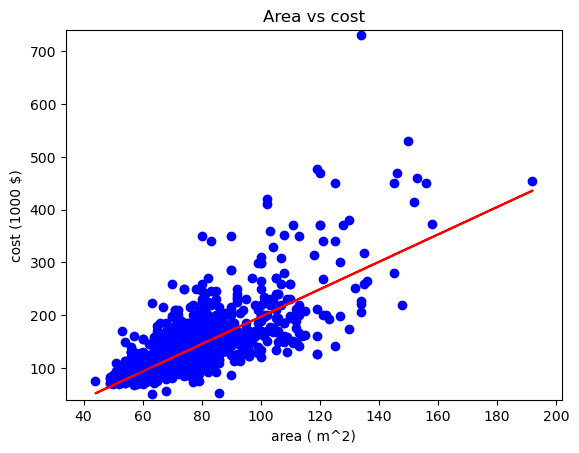

    cnt  Real Y  Predict Y         B1        B2      Sum of E         r  \
0  2040  260093   260093.0 -62.044844  2.593462 -5.042011e-11  0.756042   

          R  
0  0.571599  


In [15]:
# Experiment № 1
# Description: SLR with full dataset

SLR_solv.Experiment(count=1, full_dataset=True, random_sampling=False, cnt_sample=0, viz_with_err=False)

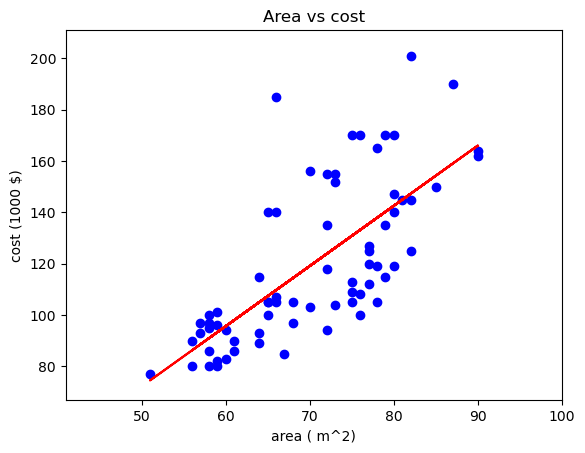

   cnt  Real Y  Predict Y         B1        B2      Sum of E         r  \
0   70    8376     8376.0 -45.163094  2.346434  1.364242e-12  0.711641   

          R  
0  0.506433  


In [16]:
# Experiment № 2
# Description: SLR with datasets sample

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=True, cnt_sample=0, viz_with_err=False)

Point 1: y_original=129, y_predict=117.41363155871612, error=11.58636844128388
Point 2: y_original=108, y_predict=112.76724966365558, error=-4.767249663655576
Point 3: y_original=219, y_predict=201.04850566980588, error=17.951494330194123
Point 4: y_original=200, y_predict=146.84071689409956, error=53.15928310590044
Point 5: y_original=120, y_predict=154.58468671920048, error=-34.58468671920048
Point 6: y_original=92, y_predict=118.9624255237363, error=-26.9624255237363
Point 7: y_original=160, y_predict=132.90157120891791, error=27.098428791082085
Point 8: y_original=145, y_predict=139.09674706899864, error=5.9032529310013615
Point 9: y_original=52, y_predict=159.231068614261, error=-107.231068614261
Point 10: y_original=145, y_predict=142.19433499903903, error=2.805665000960971
Point 11: y_original=210, y_predict=135.9991591389583, error=74.0008408610417
Point 12: y_original=93, y_predict=125.15760138381702, error=-32.157601383817024
Point 13: y_original=148, y_predict=140.6455410340

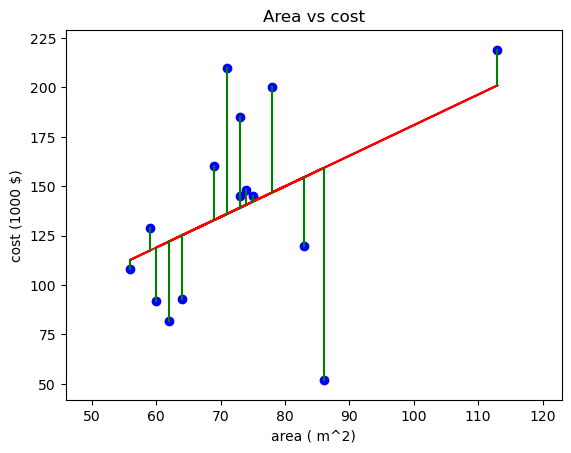

   cnt  Real Y  Predict Y         B1        B2      Sum of E         r  \
0   15    2088     2088.0  26.034788  1.548794  4.263256e-14  0.439654   

          R  
0  0.193296  


In [17]:
# Experiment № 3
# Description: SLR with datasets sample

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=False, cnt_sample=15,  viz_with_err=True)

In [18]:
# Experiment № 4
# Description: many SLR with datasets sample

SLR_solv.Experiment(count=50, full_dataset=False, random_sampling=True, cnt_sample=0,  viz_with_err=False)

    cnt  Real Y  Predict Y          B1        B2      Sum of E         r  \
0    50    6081     6081.0  -25.622588  2.102865 -1.278977e-13  0.769212   
1    63    8495     8495.0  -11.524978  1.876872 -4.405365e-13  0.796205   
2    95   12298    12298.0  -90.301714  3.022537 -1.762146e-12  0.820197   
3    76   10194    10194.0  -92.143808  3.123307  1.136868e-13  0.783727   
4    50    6464     6464.0 -115.150728  3.434946 -7.105427e-13  0.759349   
5    27    3051     3051.0   -3.105122  1.667467  5.684342e-14  0.650375   
6    67    8636     8636.0  -89.028592  3.021713 -4.547474e-13  0.711432   
7    93   12031    12031.0  -50.080069  2.445194  0.000000e+00  0.690475   
8    60    7448     7448.0  -29.515344  2.058714 -5.542233e-13  0.672659   
9    78    9823     9823.0  -78.560260  2.809211  7.389644e-13  0.798027   
10   33    4055     4055.0  -36.758345  2.184996  6.110668e-13  0.577607   
11   24    2656     2656.0   12.965151  1.421113 -2.273737e-13  0.529931   
12   72    8